In [1]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pers_experiments = "(hostname == 'scyper22' or hostname == 'scyper21')"

libraries = ["g1_v6-ref-ignore-build", "livegraph3_ro", "llama8-ref", "sortledton", "stinger7-ref", "teseo-lcc.12"]
#libraries = ["g1_v6-ref-ignore-build", "livegraph3_ro", "sortledton", "teseo-lcc.12", "llama8-ref"]
libraries_filter = " | ".join(map(lambda l: "library == '" + l + "'", libraries))

edges_per_graph = pd.DataFrame({
    "graph": ["com-friendster", "dota-league", "graph500-22", 
              "graph500-24", "graph500-26", "uniform-22", 
              "uniform-24", "uniform-26"
              ],
    "edges": [1806067135, 50870313, 64155735, 260379520, 1051922853, 64155735, 260379520, 1051922853]
})

scaling_graphs="graph == 'graph500-24'"


In [2]:
data = common.import_gfe("view_updates_throughput").query(pers_experiments) # data from the experiments
throughput_grouped = data.groupby(["graph", "library"]).agg(throughput_mean=("throughput", "mean"))

In [3]:
throughput_pivot = throughput_grouped.pivot_table(values="throughput_mean", columns="library", index="graph")
throughput_pivot

library,g1_v6-ref-ignore-build,livegraph3_ro,llama8-ref,sortledton,sortledton.1,stinger7-ref,teseo-lcc.12
graph,,,,,,,
graph500-24,39148.122353,329542.331892,131979.908950,4.162498e+06,3.611305e+06,1.102623e+05,3.966380e+06
uniform-24,967440.953828,329425.523532,317118.098842,6.301616e+06,NaN,7.594803e+06,4.088582e+06


<AxesSubplot:ylabel='Throughput [eps]'>

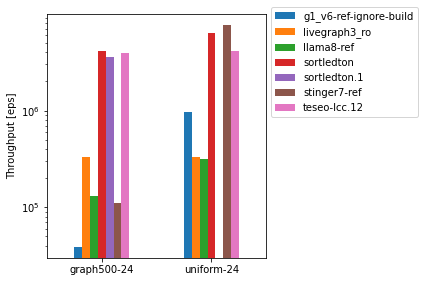

In [4]:
path = os.environ["HOME"] + "/workspace/sortledton/src/figures/throughput_average.png"

p = throughput_pivot.plot.bar()
p.legend(bbox_to_anchor=(1.0, 1.05))
p.set_yscale('log')
plt.ylabel("Throughput [eps]")

plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(path)

p

### Average Throughput Analysis

In [5]:
throughput_pivot

library,g1_v6-ref-ignore-build,livegraph3_ro,llama8-ref,sortledton,sortledton.1,stinger7-ref,teseo-lcc.12
graph,,,,,,,
graph500-24,39148.122353,329542.331892,131979.908950,4.162498e+06,3.611305e+06,1.102623e+05,3.966380e+06
uniform-24,967440.953828,329425.523532,317118.098842,6.301616e+06,NaN,7.594803e+06,4.088582e+06


We analyse the difference between the throughput on the insertion only experiment vs the throughput in the aging experiment. The main difference here are the existence of deletions. The upper row shows insertions only the lower row covers deletions as well.

                 sorltedton       Teseo          graphone        stinger         llama             livegraph
graph500-24 	4.159380e+06 	3.065291e+06 	3.838932e+06 	1.069433e+05 	288306.581456 	345147.617356

                                           
graph500-24 	4.162498e+06    3.900976e+06     59983.644444   110449.28377    131979.90895    332006.371884

For livegraph, Stinger and sortledton, we observe not signficant differences. Sorteldton treats deletions as insertsions, except for cleaning up also the edge record itself on GCing deletions. 

Teseo profits from deletions as it needs to do fewer rebalances[dean,peter].

Both LLAMA and Graphone struggle with deletions which has been explained in depth in Teseo. 



## Memory consumption

In [6]:
memory_consumption_data = common.import_gfe("view_updates_memory_footprint").query(pers_experiments)
memory_consumption_data["memory_usage_gb"] = memory_consumption_data["memory_usage_bytes"] / 1e9
memory_consumption_data["progress"] = memory_consumption_data["progress"].round(2)
#memory_consumption_data = memory_consumption_data[memory_consumption_data["library"] == "sortledton"]
grouped = memory_consumption_data.groupby(["graph", "library", "exec_id"]).agg(m=("memory_usage_gb", "max"))
grouped

m
graph       library                exec_id            
graph500-24 g1_v6-ref-ignore-build 16550     37.821400
            livegraph3_ro          16549    214.550812
            llama8-ref             16427    209.541899
                                   16532    210.416847
                                   16535    209.615561
            sortledton             16544     18.229719
            sortledton.1           17861     18.483400
            stinger7-ref           16547     27.888060
            teseo-lcc.12           16545     48.430625
uniform-24  g1_v6-ref-ignore-build 16556    106.681984
            livegraph3_ro          16554    206.808074
            llama8-ref             16555    223.559187
            sortledton             16557     21.074117
            stinger7-ref           16553     29.363470
            teseo-lcc.12           16552     46.507296

In [7]:
memory_consumption_data_graph500 = memory_consumption_data.query("graph == 'graph500-24'")
memory_consumption_pivot = memory_consumption_data_graph500.pivot_table(values="memory_usage_gb", columns="library", index="progress")
memory_consumption_pivot.interpolate(method="index", inplace=True, limit=1)

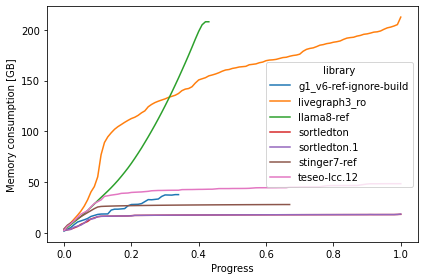

In [8]:
path = os.environ["HOME"] + "/workspace/sortledton/src/figures/memory_consumption.png"

memory_consumption_pivot.plot.line()
plt.xlabel("Progress")
plt.ylabel("Memory consumption [GB]")
plt.tight_layout()
plt.savefig(path)

In [9]:
memory_consumption_data_uniform = memory_consumption_data.query("graph == 'uniform-24'")
memory_consumption_pivot = memory_consumption_data_uniform.pivot_table(values="memory_usage_gb", columns="library", index="progress")
memory_consumption_pivot.interpolate(method="index", inplace=True, limit=4)

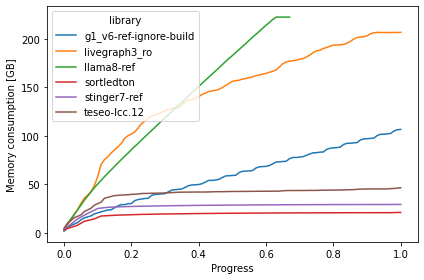

In [10]:
path = os.environ["HOME"] + "/workspace/sortledton/src/figures/memory_consumption_uniform.png"

memory_consumption_pivot.plot.line()
plt.xlabel("Progress")
plt.ylabel("Memory consumption [GB]")
plt.tight_layout()
plt.savefig(path)

### Comparision unifrom vs graph500
The memory consumption trends and ranking is equal for both graphs. In the paper, we show only graph500.

## Throughput

In [17]:
throughput_data = common.import_gfe("view_updates_throughput").query(pers_experiments)
throughput_data["minute"] = (throughput_data["second"] / 60).round(1)

In [18]:
pivot_throughput_data_graph500 = throughput_data.query("graph == 'graph500-24'").pivot_table(index="minute", columns="library", values="throughput")
pivot_throughput_data_uniform = throughput_data.query("graph == 'uniform-24'").pivot_table(index="minute", columns="library", values="throughput")


pivot_throughput_data_graph500 = pivot_throughput_data_graph500.query("minute < 120")

<AxesSubplot:xlabel='Time [minutes]', ylabel='Throughput [eps]'>

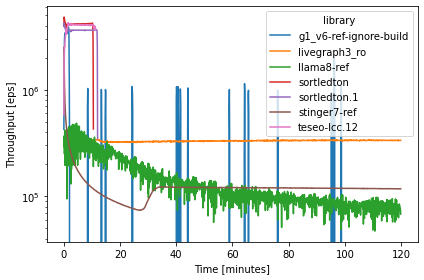

In [19]:
path = os.environ["HOME"] + "/workspace/sortledton/src/figures/throughput.png"


p = pivot_throughput_data_graph500.plot.line()

p.set_yscale('log')
plt.ylabel("Throughput [eps]")
#p.legend(bbox_to_anchor=(1.0, 1.05))

plt.xlabel("Time [minutes]")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(path)

p

In [ ]:
path = os.environ["HOME"] + "/workspace/sortledton/src/figures/throughput_uniform.png"


p = pivot_throughput_data_uniform.plot.line()

p.set_yscale('log')
plt.ylabel("Throughput [eps]")
#p.legend(bbox_to_anchor=(1.0, 1.05))

plt.xlabel("Time [minutes]")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(path)

p

### Throughput explanation

#### Graph500 vs uniform

We see equal tendencies as for inserts only: most systems are faster to varying degree for uniform graphs, the ranking is similar to inserts only (stringer, sortledton, teseo, graphone, llama, livegraph). 

We see equal tendencies as for graph500 in the throughput over time but to lesser degree. We show only the graph500 in the paper.

#### General
All graphs drop to a very low value in the end, as only a few threads run the last updates of the experiment. 
We remove that drop for the paper in the end.

#### Stinger

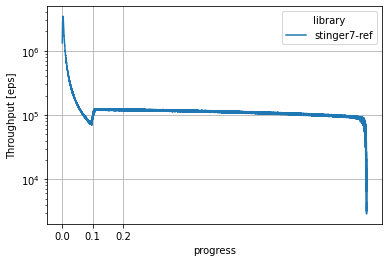

In [20]:
temp = throughput_data.query("graph == 'graph500-24'").query("library == 'stinger7-ref'")
pivot_throughput_data_on_progress = temp.pivot_table(index="progress", columns="library", values="throughput")

p = pivot_throughput_data_on_progress.plot.line()

p.set_yscale('log')
plt.ylabel("Throughput [eps]")
plt.xticks([0.0, 0.1, 0.2])
plt.grid()

We see that Stinger throughput drops from 0.0 to 0.1 percent of progress to stabilize after at a slighly higher values. 

At 0.1 progress the graph reached its maximum size. After deletions and insertions balance each other. 

Until 0.1 progress, Stinger needs to allocate new blocks and the data structure grows. Additional memory pressure and exponentially growing adjacency sets (hub vertices) lead to decreasing throughput. 

After 0.1 progress, all updates and deletes are in place for Stinger. We see slightly higher and stable througput.

#### LLAMA

For LLAMA, we observe slowly decreasing throughput. Also, the throughput is unstable and varies by roughly 100k edges per second.

LLAMA creates a new snapshot every 10 seconds. Since, they do not implement any garbage collection, memory pressure increases and their throughput sinks - see also plot of memory usage.

The througput varies because they cannot create a snapshot while inserting vertices. 


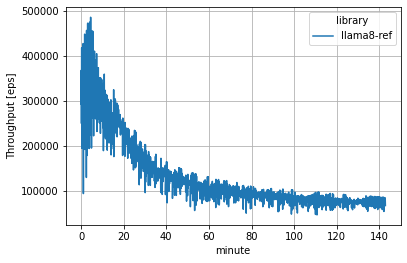

In [21]:
temp = throughput_data.query("graph == 'graph500-24'").query("library=='llama8-ref'")
pivot_llama = temp.pivot_table(index="minute", columns="library", values="throughput")

p = pivot_llama.plot.line()
plt.ylabel("Throughput [eps]")
plt.grid()